In [40]:
!pip install catboost
!pip install lime shap lightgbm xgboost


In [41]:
# GREENGO — Optimized Pipeline with Interpretability & Visualizations

import os, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import joblib

# Interpretability imports
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available - install with: pip install shap")

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME not available - install with: pip install lime")

warnings.filterwarnings("ignore")

# Config
DATA_PATH = "/content/drive/MyDrive/greengo_dataset_with_driving_logic.csv"
TARGET = "seconds_to_next_change"
TIMESTAMP_COL = "timestamp"
OUTDIR = Path("/content/greengo_optimized_artifacts")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Plot styles
plt.style.use('default')
sns.set_palette("husl")


In [42]:
df = pd.read_csv(DATA_PATH)
df.head()

,timestamp,intersection_id,current_light,seconds_to_next_change,vehicle_count,pedestrian_count,weather_condition,day_of_week,time_of_day,latitude,...,speed_limit_kmh,distance_to_next_light_m,eta_to_light_s,predicted_state_at_arrival,recommended_speed_kmh,lead_vehicle_speed_kmh,headway_seconds,congestion_level,can_make_green,safe_braking_required
0,2025-07-18 00:00:00,103,Yellow,6,31,21,Sunny,Friday,Night,43.857449,...,50.0,293.798293,22.870759,Red,35.000000,45.332327,2.081524,Free,False,True
1,2025-07-18 00:05:00,104,Green,85,37,5,Sunny,Friday,Night,43.739909,...,50.0,239.443048,18.380487,Green,46.897287,45.892857,2.222042,Free,True,False
2,2025-07-18 00:10:00,101,Green,34,2,10,Sunny,Friday,Night,43.759191,...,50.0,188.883339,14.772970,Green,46.028661,44.832560,1.933052,Free,True,False
3,2025-07-18 00:15:00,103,Red,107,15,2,Sunny,Friday,Night,43.826181,...,50.0,331.244557,25.947600,Red,30.000000,42.703062,2.009681,Free,False,False
4,2025-07-18 00:20:00,103,Yellow,75,19,3,Sunny,Friday,Night,43.833829,...,50.0,357.847885,28.051198,Yellow,35.000000,42.598879,1.532758,Free,False,True


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   5762 non-null   object 
 1   intersection_id             5762 non-null   int64  
 2   current_light               5762 non-null   object 
 3   seconds_to_next_change      5762 non-null   int64  
 4   vehicle_count               5762 non-null   int64  
 5   pedestrian_count            5762 non-null   int64  
 6   weather_condition           5762 non-null   object 
 7   day_of_week                 5762 non-null   object 
 8   time_of_day                 5762 non-null   object 
 9   latitude                    5762 non-null   float64
 10  longitude                   5762 non-null   float64
 11  acceleration                5762 non-null   float64
 12  visibility_category         5762 non-null   object 
 13  visibility_meters           5762 

In [44]:
print("\n--- Data Types ---")
print(df.dtypes.value_counts())

print("\n--- Duplicate Records ---")
print(f"Exact duplicates: {df.duplicated().sum()}")


--- Data Types ---
float64    11
object      9
int64       4
bool        2
Name: count, dtype: int64

--- Duplicate Records ---
Exact duplicates: 0


In [45]:
df.isnull().sum()

,0
timestamp,0
intersection_id,0
current_light,0
seconds_to_next_change,0
vehicle_count,0
pedestrian_count,0
weather_condition,0
day_of_week,0
time_of_day,0
latitude,0


In [46]:
# Summary statistics
df.describe(include='all')

,timestamp,intersection_id,current_light,seconds_to_next_change,vehicle_count,pedestrian_count,weather_condition,day_of_week,time_of_day,latitude,...,speed_limit_kmh,distance_to_next_light_m,eta_to_light_s,predicted_state_at_arrival,recommended_speed_kmh,lead_vehicle_speed_kmh,headway_seconds,congestion_level,can_make_green,safe_braking_required
count,5762,5762.000000,5762,5762.000000,5762.000000,5762.000000,5762,5762,5762,5762.000000,...,5762.0,5762.000000,5762.000000,5762,5762.000000,5762.000000,5762.000000,5762,5762,5762
unique,5762,NaN,3,NaN,NaN,NaN,4,7,4,NaN,...,NaN,NaN,NaN,3,NaN,NaN,NaN,2,2,2
top,2026-01-16 00:00:00,NaN,Green,NaN,NaN,NaN,Sunny,Saturday,Night,NaN,...,NaN,NaN,NaN,Yellow,NaN,NaN,NaN,Free,False,False
freq,1,NaN,1957,NaN,NaN,NaN,2400,864,1442,NaN,...,NaN,NaN,NaN,1936,NaN,NaN,NaN,4623,3831,3835
mean,NaN,102.485942,NaN,62.052065,24.367060,14.319334,NaN,NaN,NaN,43.747707,...,50.0,299.292189,29.432886,NaN,33.498550,42.005827,2.251134,NaN,NaN,NaN
std,NaN,1.128397,NaN,32.986919,14.434528,8.601220,NaN,NaN,NaN,0.085742,...,0.0,60.207841,11.569384,NaN,7.597932,6.452078,0.603002,NaN,NaN,NaN
min,NaN,101.000000,NaN,5.000000,0.000000,0.000000,NaN,NaN,NaN,43.600033,...,50.0,120.000000,8.695191,NaN,12.139767,20.596688,1.500013,NaN,NaN,NaN
25%,NaN,101.000000,NaN,33.000000,12.000000,7.000000,NaN,NaN,NaN,43.673995,...,50.0,259.129152,21.545662,NaN,30.000000,41.812522,1.807024,NaN,NaN,NaN
50%,NaN,102.000000,NaN,63.000000,24.000000,14.000000,NaN,NaN,NaN,43.747635,...,50.0,298.017986,26.159182,NaN,31.353235,44.269153,2.117394,NaN,NaN,NaN
75%,NaN,104.000000,NaN,90.000000,37.000000,22.000000,NaN,NaN,NaN,43.820304,...,50.0,339.235394,34.575810,NaN,35.000000,45.984675,2.436909,NaN,NaN,NaN


In [47]:
#Drop intersection_id
df = df.drop(columns=['intersection_id'])

In [48]:
# Drop intersection_id if present
if 'intersection_id' in df.columns:
    df = df.drop(columns=['intersection_id'])

# Convert timestamp to datetime
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors='coerce')
df.info()

# Identify numeric / datetime / categorical columns
num_cols = df.select_dtypes(include=np.number).columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
cat_cols = df.select_dtypes(exclude=[np.number, 'datetime64[ns]']).columns

print("\nNumeric:", list(num_cols))
print("Categorical:", list(cat_cols))
print("Datetime:", list(datetime_cols))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   5762 non-null   datetime64[ns]
 1   current_light               5762 non-null   object        
 2   seconds_to_next_change      5762 non-null   int64         
 3   vehicle_count               5762 non-null   int64         
 4   pedestrian_count            5762 non-null   int64         
 5   weather_condition           5762 non-null   object        
 6   day_of_week                 5762 non-null   object        
 7   time_of_day                 5762 non-null   object        
 8   latitude                    5762 non-null   float64       
 9   longitude                   5762 non-null   float64       
 10  acceleration                5762 non-null   float64       
 11  visibility_category         5762 non-null   object      

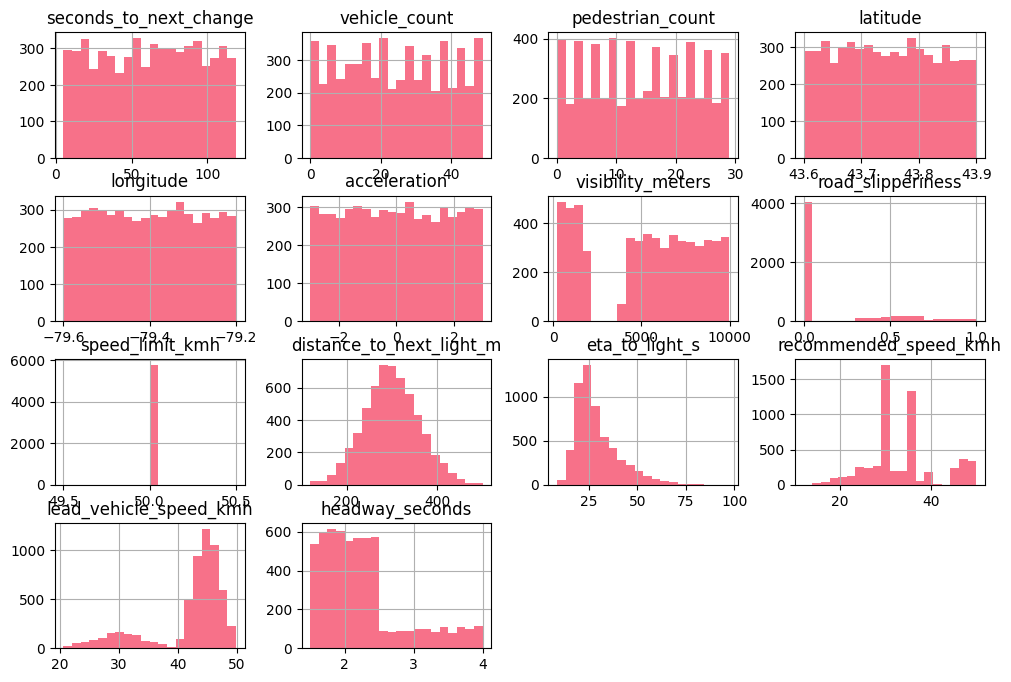

In [49]:
df[num_cols].hist(figsize=(12,8), bins=20)
plt.show()


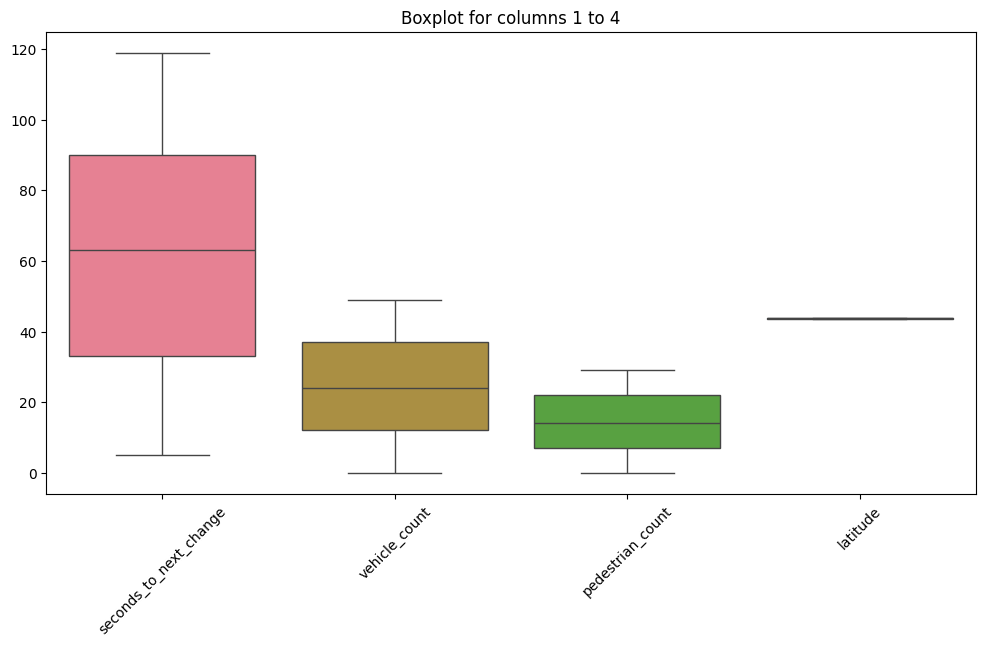

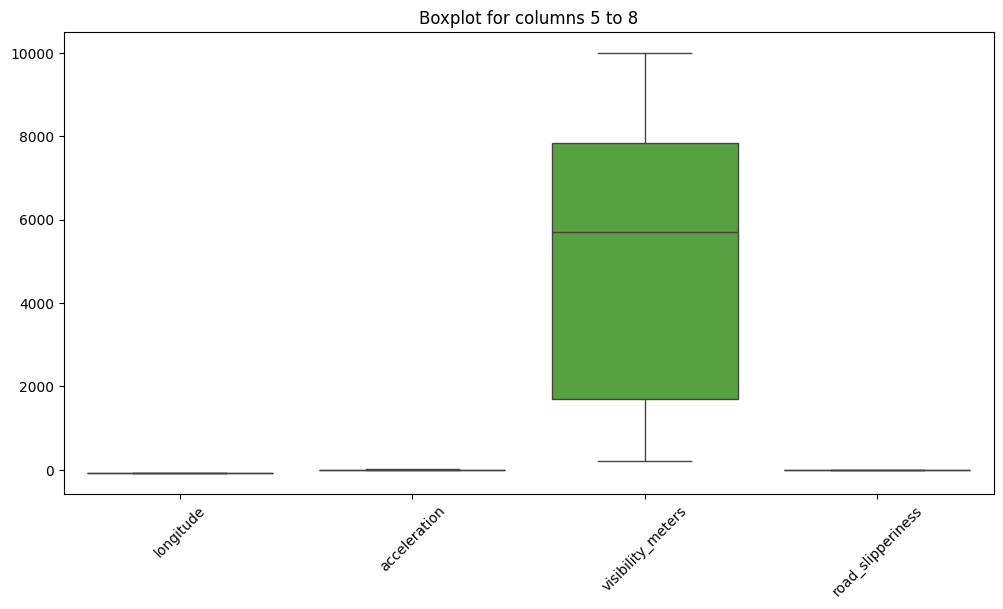

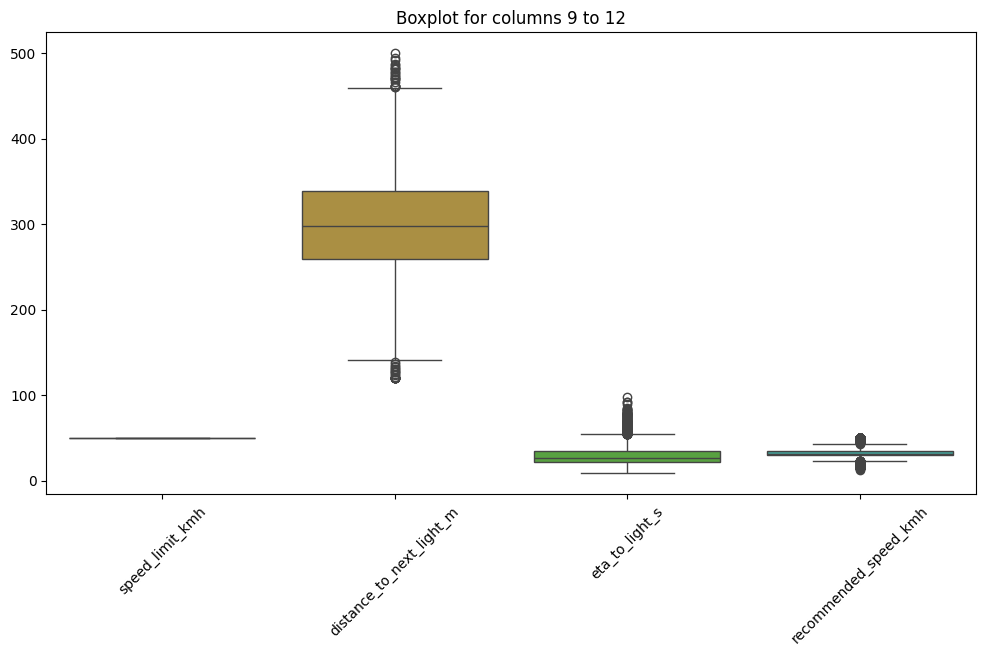

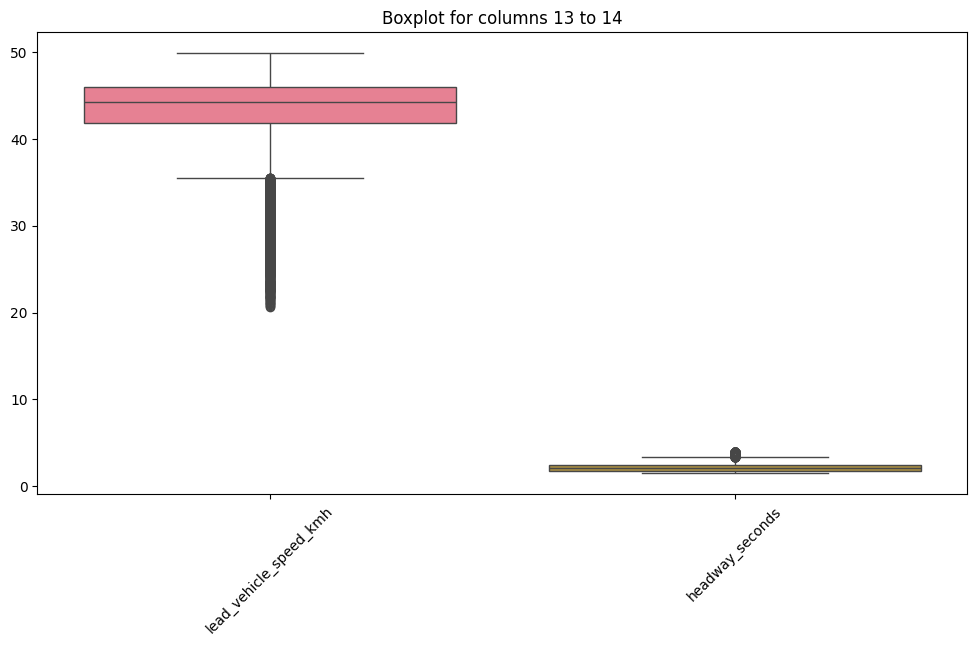

In [50]:
# Number of columns per figure
cols_per_fig = 4

# Get all numeric columns
numeric_cols = list(df[num_cols])

# Split columns into chunks
for i in range(0, len(numeric_cols), cols_per_fig):
    subset_cols = numeric_cols[i:i+cols_per_fig]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[subset_cols])
    plt.title(f'Boxplot for columns {i+1} to {i+len(subset_cols)}')
    plt.xticks(rotation=45)
    plt.show()

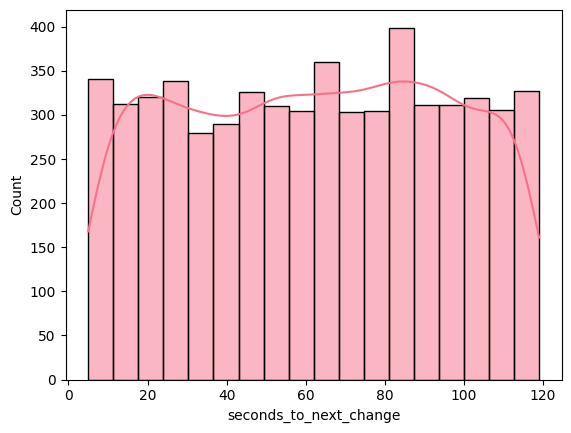

In [51]:
#visualizing the target variable
sns.histplot(df['seconds_to_next_change'], kde=True)
plt.show()


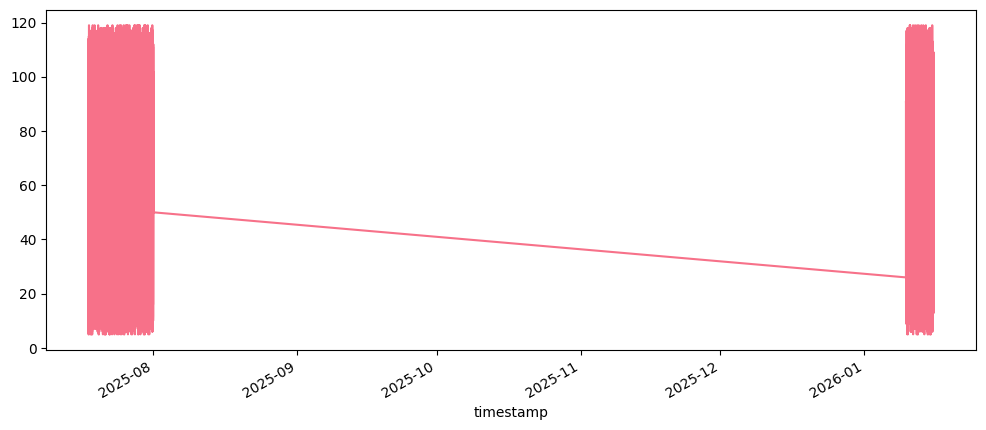

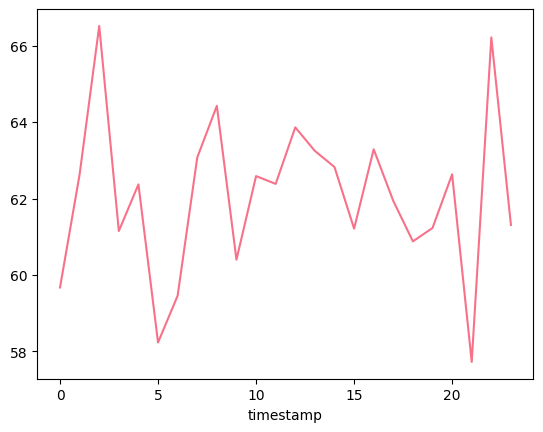

In [52]:
# Trend over time
df.set_index('timestamp')['seconds_to_next_change'].plot(figsize=(12,5))
plt.show()

# Aggregated by hour/day
df.groupby(df['timestamp'].dt.hour)['seconds_to_next_change'].mean().plot()
plt.show()


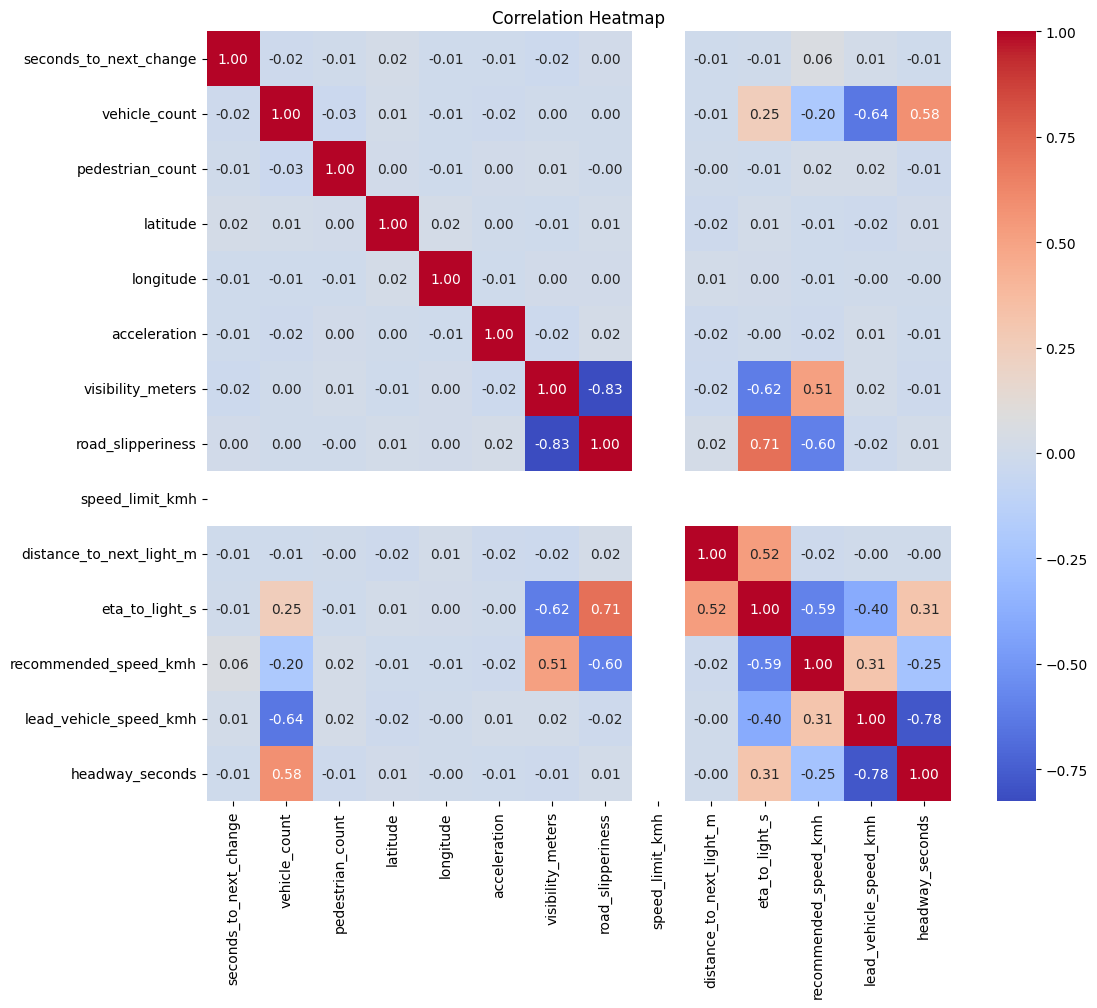

In [53]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

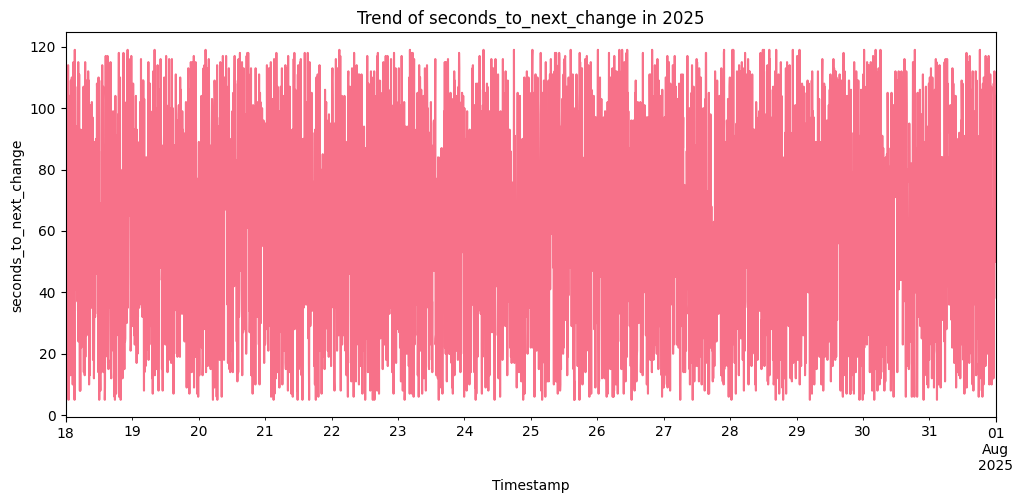

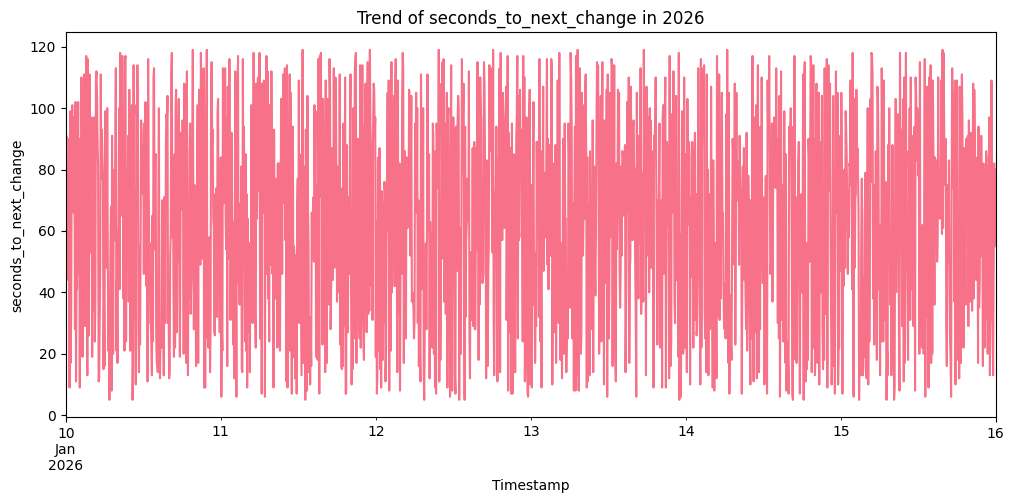

In [54]:
# Trend for 2025
if TIMESTAMP_COL in df.columns:
    df_2025 = df[df[TIMESTAMP_COL].dt.year == 2025]
    if not df_2025.empty:
        plt.figure(figsize=(12, 5))
        df_2025.set_index(TIMESTAMP_COL)[TARGET].plot()
        plt.title("Trend of seconds_to_next_change in 2025")
        plt.ylabel("seconds_to_next_change")
        plt.xlabel("Timestamp")
        plt.show()

# Trend for 2026
if TIMESTAMP_COL in df.columns:
    df_2026 = df[df[TIMESTAMP_COL].dt.year == 2026]
    if not df_2026.empty:
        plt.figure(figsize=(12, 5))
        df_2026.set_index(TIMESTAMP_COL)[TARGET].plot()
        plt.title("Trend of seconds_to_next_change in 2026")
        plt.ylabel("seconds_to_next_change")
        plt.xlabel("Timestamp")
        plt.show()


In [55]:
# Define features
categorical_features = [
    'current_light', 'weather_condition', 'day_of_week', 'time_of_day',
    'visibility_category', 'slipperiness_category',
    'predicted_state_at_arrival', 'congestion_level', 'can_make_green',
    'safe_braking_required'
]

numeric_features = [
    'vehicle_count', 'pedestrian_count', 'latitude', 'longitude',
    'acceleration', 'visibility_meters', 'road_slipperiness',
    'speed_limit_kmh', 'distance_to_next_light_m', 'eta_to_light_s',
    'recommended_speed_kmh', 'lead_vehicle_speed_kmh', 'headway_seconds'
]

target_col = TARGET

print("Handling missing values...")

# Categorical → 'unknown'
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].fillna('unknown')

# Numeric + target → median
for col in numeric_features + [target_col]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())


Handling missing values...


In [56]:
# Time-based split mask
def time_aware_mask(index_like, frac=0.80):
    """Create time-based train/test split mask."""
    n = len(index_like)
    cutoff = int(n * frac)
    mask = np.zeros(n, dtype=bool)
    mask[:cutoff] = True
    return mask


# Build feature matrix from df (with OHE + scaling)
def build_matrix(df: pd.DataFrame, target: str, timestamp_col: str,
                 exclude_features: list):
    """
    Build feature matrix X and target y from df.

    Steps:
      1) detect categorical & numeric columns
      2) clean numeric (inf/NaN → median)
      3) scale numeric with StandardScaler
      4) one-hot encode categoricals
      5) concatenate [scaled numeric | one-hot cats]
      6) drop near-constant columns
    """

    # 1. Separate categorical and numeric
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = [
        c for c in df.columns
        if c not in exclude_features + categorical_cols
        and pd.api.types.is_numeric_dtype(df[c])
    ]

    # 2. Clean numeric: replace inf, fill NaN with median
    num_df = df[numerical_cols].copy()
    num_df = num_df.replace([np.inf, -np.inf], np.nan)
    num_df = num_df.fillna(num_df.median(numeric_only=True))

    # 3. Scale numeric
    scaler = StandardScaler()
    num_scaled = scaler.fit_transform(num_df)
    num_scaled_df = pd.DataFrame(
        num_scaled,
        columns=numerical_cols,
        index=df.index
    )

    # 4. One-hot encode categoricals
    try:
        encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    except TypeError:
        encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

    if categorical_cols:
        enc = encoder.fit_transform(df[categorical_cols])
        enc_df = pd.DataFrame(
            enc,
            columns=encoder.get_feature_names_out(categorical_cols),
            index=df.index
        )
        X = pd.concat([num_scaled_df, enc_df], axis=1)
    else:
        X = num_scaled_df

    # 5. Drop near-constant columns (after scaling & encoding)
    constant_cols = [c for c in X.columns if X[c].std(ddof=0) < 1e-6]
    if constant_cols:
        X = X.drop(columns=constant_cols)

    # 6. Target
    y = df[target].astype(float)

    # NOTE: We are not returning the scaler here; X is already scaled.
    return X, y, encoder, X.columns.tolist()


# Metrics
def metrics(y_true, y_pred):
    return {
        "r2": float(r2_score(y_true, y_pred)),
        "rmse": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "mae": float(mean_absolute_error(y_true, y_pred))
    }


# Tolerance table
def tolerance_table(y_true, y_pred, tolerances=(2, 5, 10, 15, 20)):
    res = {}
    err = np.abs(y_true - y_pred)
    n = len(y_true)
    for t in tolerances:
        res[f"within_±{t}s_%"] = float((err <= t).sum() * 100.0 / n)
    return res


In [57]:
def create_optimized_features_v2(df: pd.DataFrame, timestamp_col: str) -> pd.DataFrame:
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Time features
    df['hour'] = df[timestamp_col].dt.hour
    df['minute'] = df[timestamp_col].dt.minute
    df['day_of_week'] = df[timestamp_col].dt.dayofweek

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

    # Traffic patterns
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 18)).astype(int)
    df['weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Light state features
    if 'current_light' in df.columns:
        light_map = {'Green': 0, 'Yellow': 1, 'Red': 2}
        df['light_timing_code'] = df['current_light'].map(light_map)
        df['is_green'] = (df['current_light'] == 'Green').astype(int)
        df['is_red'] = (df['current_light'] == 'Red').astype(int)

    # Interactions: eta & distance
    if all(c in df.columns for c in ['eta_to_light_s', 'distance_to_next_light_m']):
        df['required_speed_ms'] = df['distance_to_next_light_m'] / (df['eta_to_light_s'] + 1)
        df['timing_urgency'] = df['eta_to_light_s'] / (df['distance_to_next_light_m'] + 1)
        df['eta_squared'] = df['eta_to_light_s'] ** 2
        df['distance_squared'] = df['distance_to_next_light_m'] ** 2
        df['eta_distance_interaction'] = df['eta_to_light_s'] * df['distance_to_next_light_m']

    # Traffic combinations
    if all(c in df.columns for c in ['vehicle_count', 'pedestrian_count']):
        df['total_traffic'] = df['vehicle_count'] + df['pedestrian_count']
        df['traffic_density'] = df['vehicle_count'] * df['pedestrian_count'] / 100
        df['rush_traffic'] = (df['morning_rush'] + df['evening_rush']) * df['total_traffic']

    # Speed relationships
    if all(c in df.columns for c in ['lead_vehicle_speed_kmh', 'speed_limit_kmh']):
        df['speed_ratio'] = df['lead_vehicle_speed_kmh'] / (df['speed_limit_kmh'] + 1)
        df['speed_deficit'] = df['speed_limit_kmh'] - df['lead_vehicle_speed_kmh']

    # Rolling averages for eta
    if 'eta_to_light_s' in df.columns:
        for window in [3, 5]:
            df[f'eta_rolling_mean_{window}'] = df['eta_to_light_s'].rolling(window=window, min_periods=1).mean()

    # Time-traffic interactions
    if 'total_traffic' in df.columns:
        df['hour_traffic'] = df['hour_sin'] * df['total_traffic']

    if 'eta_to_light_s' in df.columns:
        df['rush_urgency'] = (df['morning_rush'] + df['evening_rush']) * df['eta_to_light_s']

    return df.fillna(method='bfill').fillna(method='ffill')


In [58]:
class OptimizedLogTargetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def _transform_eval_set(self, fit_params):
        if 'eval_set' in fit_params and fit_params['eval_set'] is not None:
            new_eval = []
            for (Xe, ye) in fit_params['eval_set']:
                ye_log = np.log1p(np.clip(ye, 0, None))
                new_eval.append((Xe, ye_log))
            fit_params = dict(fit_params)
            fit_params['eval_set'] = new_eval
        return fit_params

    def fit(self, X, y, **fit_params):
        y_log = np.log1p(np.clip(y, 0, None))
        fit_params = self._transform_eval_set(fit_params)
        self.estimator.fit(X, y_log, **fit_params)
        return self

    def predict(self, X):
        pred_log = self.estimator.predict(X)
        pred = np.expm1(pred_log)
        return np.maximum(pred, 0)

    def get_params(self, deep=True):
        return {"estimator": self.estimator}

    def set_params(self, **params):
        if "estimator" in params:
            self.estimator = params["estimator"]
        return self


def get_optimized_models():
    """Return carefully tuned model configurations."""

    lgb_params = {
        'n_estimators': 2000,
        'learning_rate': 0.015,
        'max_depth': 8,
        'num_leaves': 63,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_child_samples': 20,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    xgb_params = {
        'n_estimators': 2000,
        'learning_rate': 0.015,
        'max_depth': 8,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_child_weight': 5,
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }

    cat_params = {
        'iterations': 2000,
        'learning_rate': 0.015,
        'depth': 8,
        'subsample': 0.8,
        'colsample_bylevel': 0.8,
        'l2_leaf_reg': 1.0,
        'random_state': 42,
        'verbose': False
    }

    hgb_params = {
        'max_iter': 2000,
        'learning_rate': 0.015,
        'max_depth': 8,
        'min_samples_leaf': 20,
        'l2_regularization': 0.1,
        'random_state': 42
    }

    return {
        'LGBM_Opt': OptimizedLogTargetWrapper(lgb.LGBMRegressor(**lgb_params)),
        'XGBoost_Opt': OptimizedLogTargetWrapper(xgb.XGBRegressor(**xgb_params)),
        'CatBoost_Opt': OptimizedLogTargetWrapper(CatBoostRegressor(**cat_params)),
        'HistGB_Opt': OptimizedLogTargetWrapper(HistGradientBoostingRegressor(**hgb_params))
    }


In [59]:
class AdvancedStacker:
    def __init__(self, base_models, meta_model=Ridge(alpha=0.1), n_splits=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_splits = n_splits
        self.fitted_base_models = {}

    def fit(self, X, y):
        kf = KFold(n_splits=self.n_splits, shuffle=False)
        oof_preds = np.zeros((len(X), len(self.base_models)))

        print("Training base models for stacking...")
        for model_idx, (name, model) in enumerate(self.base_models.items()):
            print(f"  {name}...")
            model_oof = np.zeros(len(X))

            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

                wrapped_model = OptimizedLogTargetWrapper(clone(model))
                wrapped_model.fit(X_tr, y_tr)

                if fold == 0:
                    self.fitted_base_models[name] = wrapped_model

                model_oof[val_idx] = wrapped_model.predict(X_val)

            oof_preds[:, model_idx] = model_oof

        self.meta_model.fit(oof_preds, y)
        return self

    def predict(self, X):
        base_preds = []
        for name, model in self.fitted_base_models.items():
            base_preds.append(model.predict(X))
        base_preds = np.column_stack(base_preds)
        return self.meta_model.predict(base_preds)


In [60]:
def create_performance_visualizations(results, y_test, outdir):
    print("Creating performance visualizations...")

    models = list(results.keys())
    r2_scores = [results[m]['r2'] for m in models]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # R2 comparison
    axes[0, 0].barh(models, r2_scores)
    axes[0, 0].set_xlabel('R² Score')
    axes[0, 0].set_title('Model R² Comparison')
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)

    # Best model predicted vs actual
    best_name = max(results.items(), key=lambda kv: kv[1]['r2'])[0]
    best_pred = results[best_name]['pred']

    axes[0, 1].scatter(y_test, best_pred, alpha=0.6, s=20)
    axes[0, 1].plot([y_test.min(), y_test.max()],
                    [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual')
    axes[0, 1].set_ylabel('Predicted')
    axes[0, 1].set_title(f'{best_name}: Predicted vs Actual\nR² = {results[best_name]["r2"]:.4f}')

    # Residuals
    residuals = y_test - best_pred
    axes[1, 0].scatter(best_pred, residuals, alpha=0.6, s=20)
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title(f'{best_name}: Residual Plot')

    # Error distribution
    axes[1, 1].hist(residuals, bins=50, edgecolor='black')
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Prediction Error')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'{best_name}: Error Distribution')

    plt.tight_layout()
    plt.savefig(outdir / "performance_visualizations.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Tolerance bar plot
    tol_results = tolerance_table(y_test.values, best_pred)
    tolerances = list(tol_results.keys())
    percentages = list(tol_results.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(tolerances, percentages)
    plt.xlabel('Tolerance (seconds)')
    plt.ylabel('Percentage within tolerance (%)')
    plt.ylim(0, 100)
    plt.title('Prediction Accuracy within Tolerance Ranges')

    for bar, p in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f"{p:.1f}%", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(outdir / "tolerance_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def create_feature_importance_plot(model, feature_names, outdir, top_n=15):
    print("Creating feature importance plot...")

    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'estimator') and hasattr(model.estimator, 'feature_importances_'):
            importances = model.estimator.feature_importances_
        else:
            print("No feature importances available.")
            return

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        top_features = importance_df.head(top_n)

        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_features['importance'][::-1])
        plt.yticks(range(len(top_features)), top_features['feature'][::-1])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Features')
        plt.tight_layout()
        plt.savefig(outdir / "feature_importance.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        importance_df.to_csv(outdir / "feature_importance.csv", index=False)

        print(f"\nTop {top_n} features:")
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

    except Exception as e:
        print(f"Feature importance visualization failed: {e}")


def create_data_distribution_plots(df, X, y, outdir):
    print("Creating data distribution plots...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Target distribution
    axes[0, 0].hist(y, bins=50, edgecolor='black')
    axes[0, 0].set_title("Target Distribution")

    # Hourly pattern
    if 'hour' in df.columns:
        hourly_avg = df.groupby('hour')[TARGET].mean()
        axes[0, 1].plot(hourly_avg.index, hourly_avg.values, marker='o')
        axes[0, 1].set_title("Average Target by Hour")
        axes[0, 1].grid(True, alpha=0.3)

    # Day of week pattern
    if 'day_of_week' in df.columns:
        daily_avg = df.groupby('day_of_week')[TARGET].mean()
        axes[1, 0].bar(daily_avg.index, daily_avg.values)
        axes[1, 0].set_title("Average Target by Day of Week")

    # Correlation with target
    correlations = []
    for col in X.columns:
        if pd.api.types.is_numeric_dtype(X[col]):
            corr = np.corrcoef(X[col], y)[0, 1]
            correlations.append((col, corr))

    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    top_corr = correlations[:10]

    if top_corr:
        axes[1, 1].barh([c[0] for c in top_corr], [c[1] for c in top_corr])
        axes[1, 1].set_title("Top 10 Feature Correlations")

    plt.tight_layout()
    plt.savefig(outdir / "data_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def perform_shap_analysis(model, X, feature_names, outdir):
    if not SHAP_AVAILABLE:
        print("SHAP not available.")
        return

    print("Performing SHAP analysis...")

    try:
        underlying_model = model.estimator if hasattr(model, 'estimator') else model

        if hasattr(underlying_model, 'feature_importances_'):
            explainer = shap.TreeExplainer(underlying_model)
        else:
            explainer = shap.Explainer(underlying_model, X)

        X_sample = X.sample(1000, random_state=42) if len(X) > 1000 else X
        shap_values = explainer.shap_values(X_sample)

        shap_dir = outdir / "shap_plots"
        shap_dir.mkdir(exist_ok=True)

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(shap_dir / "shap_summary.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                          plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig(shap_dir / "shap_bar.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        shap_df = pd.DataFrame(shap_values, columns=feature_names, index=X_sample.index)
        shap_df.to_csv(shap_dir / "shap_values.csv")

        print(f"SHAP analysis completed and saved to {shap_dir}")

    except Exception as e:
        print(f"SHAP analysis failed: {e}")


def perform_lime_analysis(model, X, y, feature_names, outdir, num_samples=5):
    if not LIME_AVAILABLE:
        print("LIME not available.")
        return

    print("Performing LIME analysis...")

    try:
        lime_dir = outdir / "lime_explanations"
        lime_dir.mkdir(exist_ok=True)

        explainer = lime.lime_tabular.LimeTabularExplainer(
            X.values,
            feature_names=feature_names,
            mode='regression',
            random_state=42
        )

        sample_indices = np.random.choice(len(X),
                                          min(num_samples, len(X)),
                                          replace=False)

        lime_results = []
        for i, idx in enumerate(sample_indices):
            actual_value = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]
            prediction = model.predict(X.iloc[idx:idx+1])[0]

            print(f"\nLIME Instance {i}: actual={actual_value:.1f}, pred={prediction:.1f}")

            exp = explainer.explain_instance(
                X.iloc[idx].values,
                model.predict,
                num_features=min(10, len(feature_names))
            )

            exp.save_to_file(lime_dir / f"lime_explanation_{i}.html")

            plt.figure(figsize=(10, 6))
            exp.as_pyplot_figure()
            plt.title(f'LIME Explanation - Instance {i}')
            plt.tight_layout()
            plt.savefig(lime_dir / f"lime_plot_{i}.png", dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

            local_importance = exp.as_list()
            lime_results.append({
                'instance_id': int(idx),
                'actual_value': float(actual_value),
                'predicted_value': float(prediction),
                'error': float(abs(actual_value - prediction)),
                'feature_contributions': local_importance
            })

        with open(lime_dir / "lime_results.json", 'w') as f:
            json.dump(lime_results, f, indent=2)

        print(f"LIME analysis completed for {len(sample_indices)} instances in {lime_dir}")

    except Exception as e:
        print(f"LIME analysis failed: {e}")


In [61]:
def train_optimized_pipeline(X_train, y_train, X_test, y_test, feature_names):
    results = {}

    print("Training optimized individual models...")
    models = get_optimized_models()

    # Individual models
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        results[name] = {
            "model": model,
            **metrics(y_test, pred),
            "pred": pred
        }

    # Advanced stacker
    print("\nTraining Advanced Stacker...")
    base_models_for_stacking = {
        'lgb': lgb.LGBMRegressor(
            n_estimators=1500, learning_rate=0.02, max_depth=7,
            num_leaves=63, random_state=42, verbose=-1
        ),
        'xgb': xgb.XGBRegressor(
            n_estimators=1500, learning_rate=0.02, max_depth=7,
            random_state=42
        ),
        'cat': CatBoostRegressor(
            iterations=1500, learning_rate=0.02, depth=7,
            random_state=42, verbose=False
        ),
        'hgb': HistGradientBoostingRegressor(
            max_iter=1500, learning_rate=0.02, max_depth=7,
            random_state=42
        )
    }

    stacker = AdvancedStacker(base_models_for_stacking, meta_model=Ridge(alpha=0.1))
    stacker.fit(X_train, y_train)
    stack_pred = stacker.predict(X_test)

    results['Advanced_Stack'] = {
        "model": stacker,
        **metrics(y_test, stack_pred),
        "pred": stack_pred
    }

    # Blend top models
    print("\nCreating blended ensemble...")
    top_models = ['LGBM_Opt', 'CatBoost_Opt', 'Advanced_Stack']
    if all(m in results for m in top_models):
        top_preds = [results[m]['pred'] for m in top_models]
        blended_pred = np.mean(top_preds, axis=0)

        results['Blended_Top3'] = {
            "model": {m: results[m]['model'] for m in top_models},
            **metrics(y_test, blended_pred),
            "pred": blended_pred
        }

    return results


=== GREENGO — Optimized Pipeline with Interpretability ===
Train: (4609, 54) | Test: (1153, 54)

=== DATA EXPLORATION (ENGINEERED) ===
Creating data distribution plots...


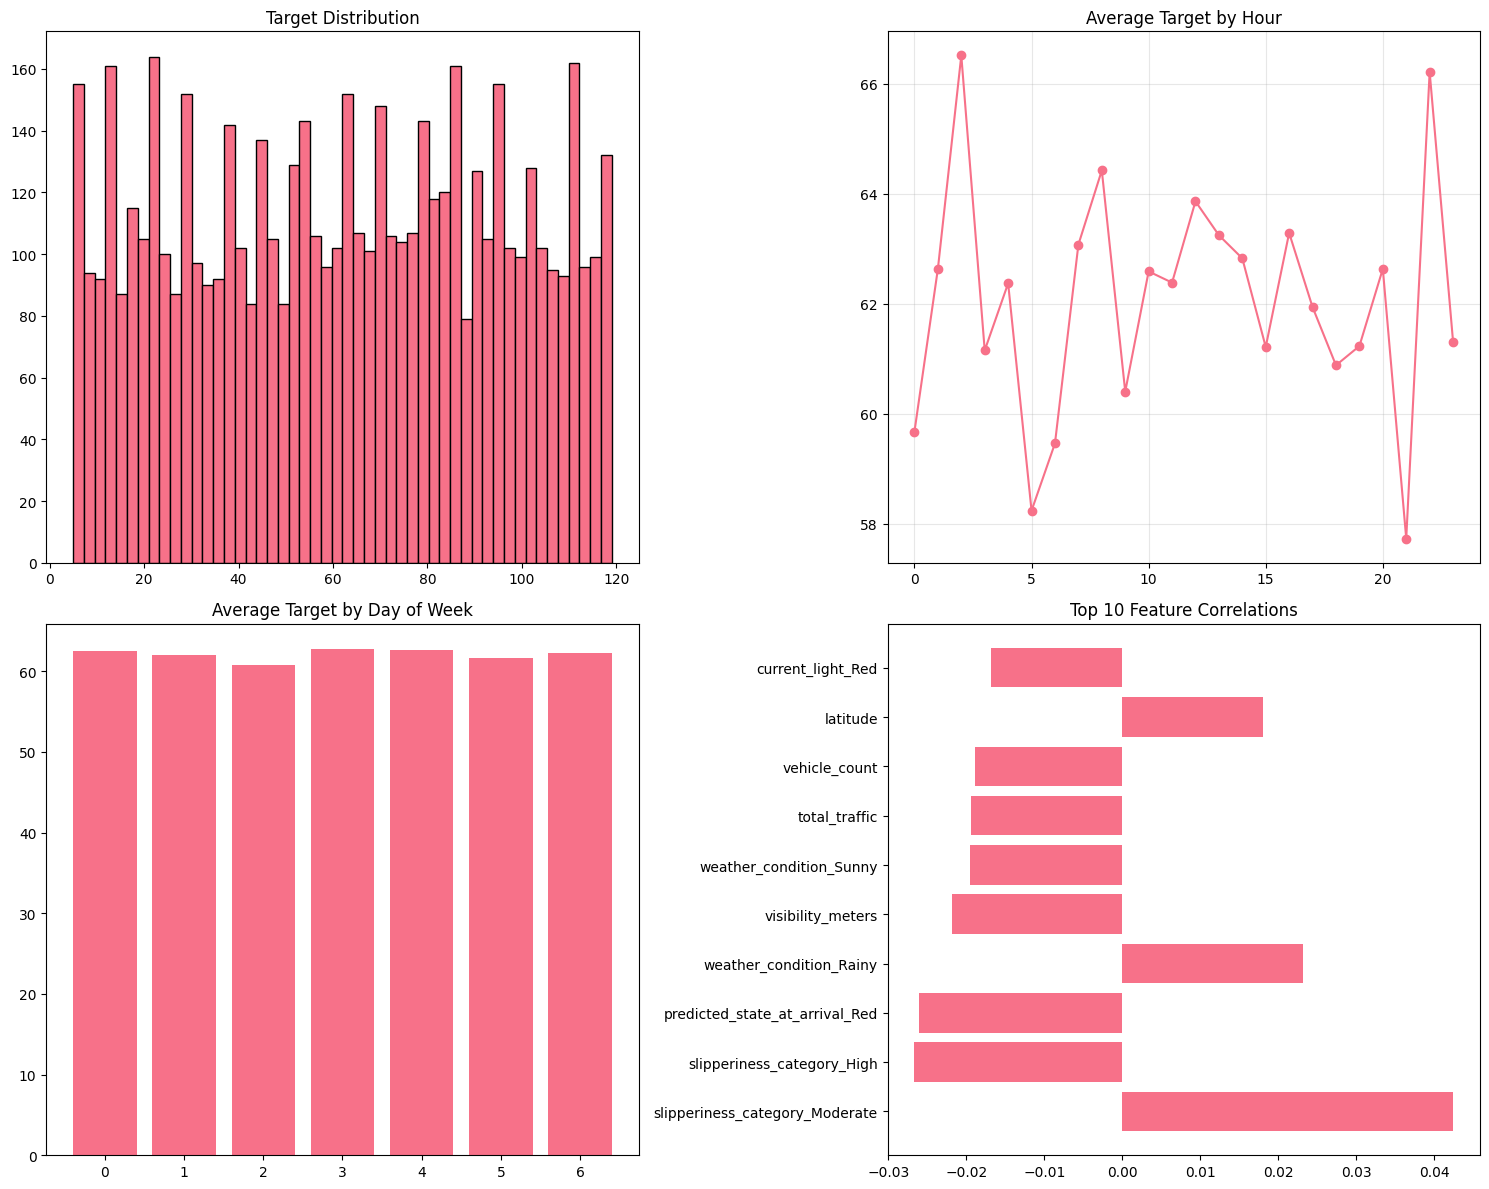

Training optimized individual models...
Training LGBM_Opt...
Training XGBoost_Opt...
Training CatBoost_Opt...
Training HistGB_Opt...

Training Advanced Stacker...
Training base models for stacking...
  lgb...
  xgb...
  cat...
  hgb...

Creating blended ensemble...

FINAL OPTIMIZED RESULTS
Model                      R²       RMSE        MAE
------------------------------------------------------------
Advanced_Stack         0.5369      22.41      18.12
CatBoost_Opt           0.5079      23.10      18.47
Blended_Top3           0.4954      23.39      18.92
LGBM_Opt               0.2730      28.07      22.63
XGBoost_Opt            0.2545      28.43      22.90
HistGB_Opt             0.2409      28.69      23.23

=== PERFORMANCE SUMMARY ===
Baseline R²:    0.5205
New Best R²:    0.5369
Improvement:    +3.15%

=== TOLERANCE ANALYSIS ===
  within_±2s_%: 8.9%
  within_±5s_%: 17.5%
  within_±10s_%: 33.7%
  within_±15s_%: 47.9%
  within_±20s_%: 61.1%

=== CREATING VISUALIZATIONS ===
Creating perf

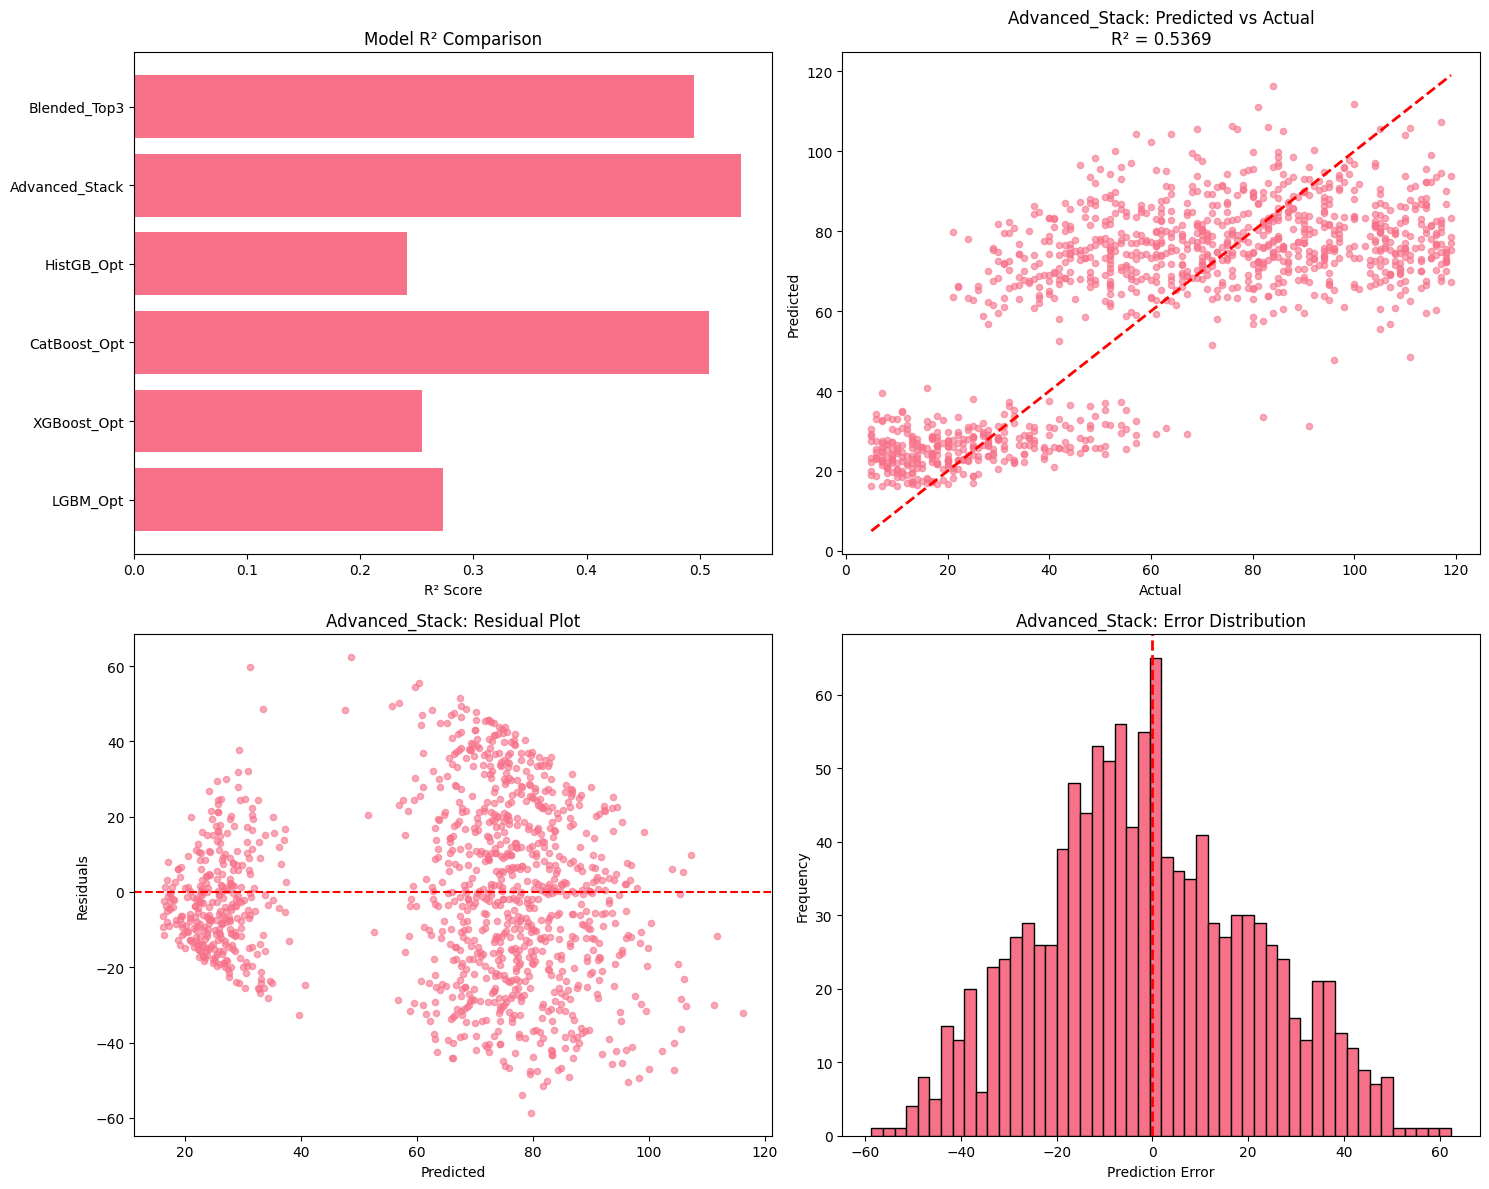

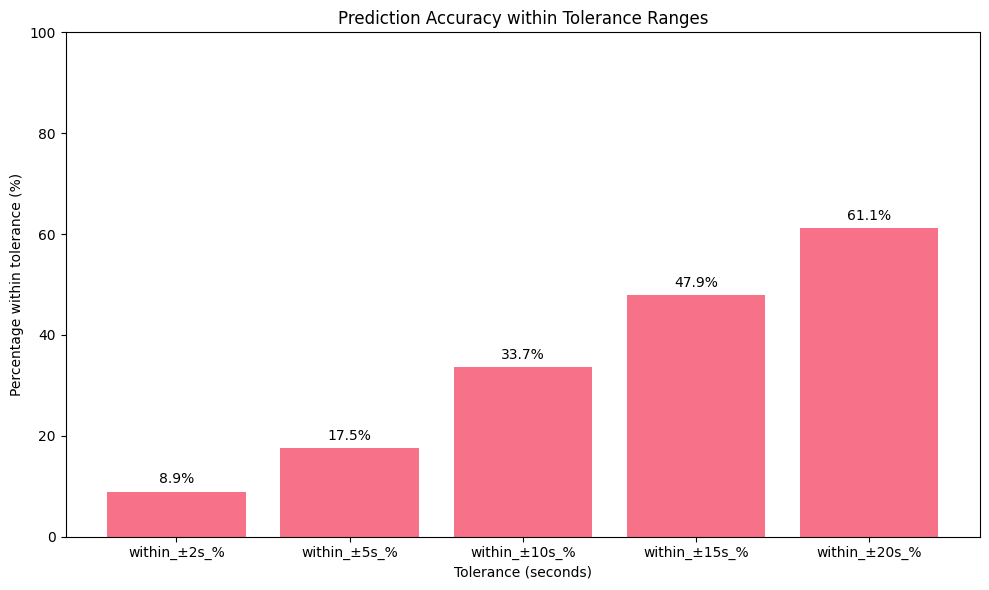

Creating feature importance plot...
No feature importances available.

=== SHAP ANALYSIS ===
Performing SHAP analysis...
SHAP analysis failed: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <__main__.AdvancedStacker object at 0x7fadc0f9cb00>

=== OPTIONAL: LIME ANALYSIS ===
Performing LIME analysis...

LIME Instance 0: actual=41.0, pred=81.2


<Figure size 1000x600 with 0 Axes>

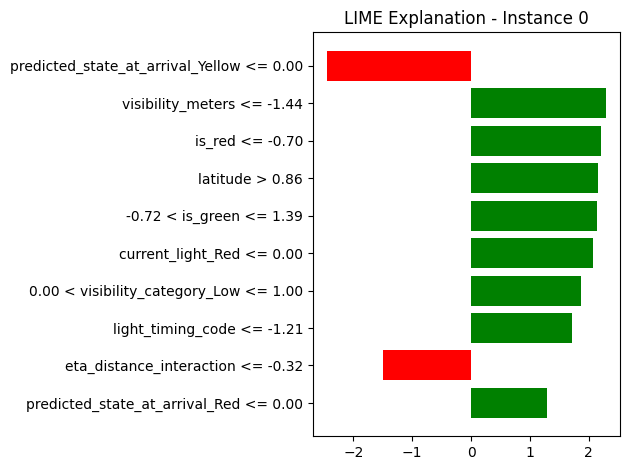


LIME Instance 1: actual=94.0, pred=73.4


<Figure size 1000x600 with 0 Axes>

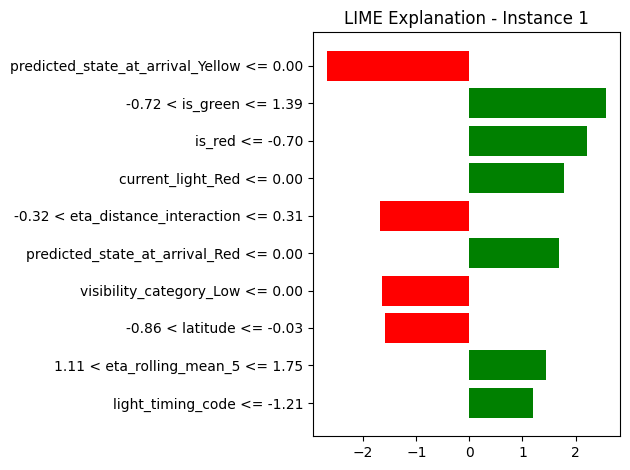


LIME Instance 2: actual=86.0, pred=75.8


<Figure size 1000x600 with 0 Axes>

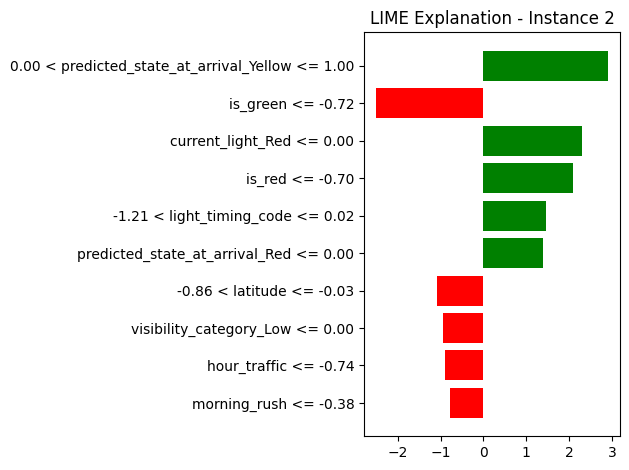

LIME analysis completed for 3 instances in /content/greengo_optimized_artifacts/lime_explanations

Artifacts saved to: /content/greengo_optimized_artifacts
Total features used: 54

=== VISUALIZATION SUMMARY ===
✓ EDA plots
✓ Data distribution plots
✓ Performance visualizations
✓ Feature importance plots
✓ SHAP analysis plots
✓ LIME explanations
✓ All plots displayed and saved


In [62]:
print("=== GREENGO — Optimized Pipeline with Interpretability ===")

# Start from cleaned df already loaded & preprocessed above
df_proc = create_optimized_features_v2(df.copy(), TIMESTAMP_COL)

# Columns to exclude from X
exclude = [
    TARGET,
    TIMESTAMP_COL,
    'recommended_speed_kmh',
    'can_make_green',
    'safe_braking_required',
    'predicted_state_at_arrival'
]

X, y, encoder, feature_names = build_matrix(df_proc, TARGET, TIMESTAMP_COL, exclude)

# Time-based ordering
df_order = df_proc[[TIMESTAMP_COL]].copy()
df_order.index = df_proc.index
df_order = df_order.sort_values(TIMESTAMP_COL)

mask = time_aware_mask(df_order.index, frac=0.8)

X_all = X.loc[df_order.index]
y_all = y.loc[df_order.index]

X_train, X_test = X_all[mask], X_all[~mask]
y_train, y_test = y_all[mask], y_all[~mask]

print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# Extra data distribution plots (using engineered df)
print("\n=== DATA EXPLORATION (ENGINEERED) ===")
create_data_distribution_plots(df_proc, X, y, OUTDIR)

# Train pipeline
results = train_optimized_pipeline(X_train, y_train, X_test, y_test, feature_names)

# Leaderboard
leaderboard = sorted(results.items(), key=lambda kv: kv[1]['r2'], reverse=True)

print("\n" + "="*60)
print("FINAL OPTIMIZED RESULTS")
print("="*60)
print(f"{'Model':<20} {'R²':>8} {'RMSE':>10} {'MAE':>10}")
print("-"*60)
for name, res in leaderboard:
    print(f"{name:<20} {res['r2']:>8.4f} {res['rmse']:>10.2f} {res['mae']:>10.2f}")

best_name, best_res = leaderboard[0]
best_pred = best_res['pred']
best_model = best_res['model']

# Compare with baseline
baseline_r2 = 0.5205
improvement = ((best_res['r2'] - baseline_r2) / baseline_r2) * 100

print(f"\n=== PERFORMANCE SUMMARY ===")
print(f"Baseline R²:    {baseline_r2:.4f}")
print(f"New Best R²:    {best_res['r2']:.4f}")
print(f"Improvement:    {improvement:+.2f}%")

# Tolerance analysis
tol = tolerance_table(y_test.values, best_pred)
print(f"\n=== TOLERANCE ANALYSIS ===")
for k, v in tol.items():
    print(f"  {k}: {v:.1f}%")

print("\n=== CREATING VISUALIZATIONS ===")
create_performance_visualizations(results, y_test, OUTDIR)
create_feature_importance_plot(best_model, feature_names, OUTDIR)

print("\n=== SHAP ANALYSIS ===")
perform_shap_analysis(best_model, X_test, feature_names, OUTDIR)

print("\n=== OPTIONAL: LIME ANALYSIS ===")
perform_lime_analysis(best_model, X_test, y_test, feature_names, OUTDIR, num_samples=3)

# Save artifacts
joblib.dump(best_model, OUTDIR / "optimized_best_model.pkl")
joblib.dump(feature_names, OUTDIR / "optimized_features.pkl")

pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": best_pred
}).to_csv(OUTDIR / "optimized_predictions.csv", index=False)

print(f"\nArtifacts saved to: {OUTDIR}")
print(f"Total features used: {len(feature_names)}")

print("\n=== VISUALIZATION SUMMARY ===")
print("✓ EDA plots")
print("✓ Data distribution plots")
print("✓ Performance visualizations")
print("✓ Feature importance plots")
print("✓ SHAP analysis plots")
print("✓ LIME explanations")
print("✓ All plots displayed and saved")
